## Introduction
This notebook was created for analysis and prediction making of the *Bank marketing data set* from UCI Machine Learning Library. The data set can be accessed separately from the UCI Machine Learning Repository page, [here](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

## Relevant Papers

In their paper "A Data-Driven Approach to Predict the Success of Bank Telemarketing. (S. Moro, P. Cortez and P. Rita, June 2014)", which can be found [here](http://repositorium.sdum.uminho.pt/bitstream/1822/30994/1/dss-v3.pdf), S. Moro, P. Cortez and P. Rita, propose a data mining (DM) approach to predict the success of telemarketing calls for selling bank long-term deposits, comparing four DM models: Logistic regression, Decision trees (DT), neural network (NN) and support vector machine.

## Attribute Information

#### Bank client data
- `age`: numeric
- `job`: type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
- `marital`: marital status (categorical: 'divorced', 'married', 'single', 'unknown'; (note: 'divorced' means divorced or widowed))
- `education`:(categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
- `default`: has credit in default? (categorical: 'no','yes','unknown')
- `housing`: has housing loan? (categorical: 'no', 'yes', 'unknown')
- `loan`: has personal loan? (categorical: 'no', 'yes', 'unknown')
#### Related with the last contact of the current campaign:
- `contact`: contact communication type (categorical: 'cellular', 'telephone')
- `month`: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- `day_of_week`: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- `duration`: last contact duration, in seconds (numeric). 

**Important note:** `duration` highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
#### Other attributes:
- `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- `previous`: number of contacts performed before this campaign and for this client (numeric)
- `poutcome`: outcome of the previous marketing campaign (categorical: 'failure', 'nonexistent', 'success')
#### Social and economic context attributes
- `emp.var.rate`: employment variation rate - quarterly indicator (numeric)
- `cons.price.idx`: consumer price index - monthly indicator (numeric)
- `cons.conf.idx`: consumer confidence index - monthly indicator (numeric)
- `euribor3m`: euribor 3 month rate - daily indicator (numeric)
- `nr.employed`: number of employees - quarterly indicator (numeric)

#### Output variable (desired target):
- `y` - has the client subscribed a term deposit? (binary: 'yes', 'no')

## Models

We will create 3 models in order to make predictions and compare them with the original paper. These models are:
- Logistic Regression
- Decision tree
- Neural Network

After the initial predictions, each model will be "optimized" by `GridSearchCV` estimator, which will search for the best set of hyperparameters for every model.  

## Metrics

In order to be consistent with the original paper and have the same base for our results, we will use the same metric: receiver operating characteristic (ROC) curve. The receiver operating characteristic (ROC) curve shows the performance of a two class classifier across the range of possible threshold values, plotting one minus the specificity (x-axis) versus the sensitivity (y-axis). The overall accuracy is given by the area under the curve, measuring the degree of discrimination that can be obtained from a given model. AUC is a popular classification metric that presents advantages of being independent of the class frequency or specific false positive/negative costs. The ideal method shouldpresent an AUC of 1.0, while an AUC of 0.5 denotes a random classifier.

Additional to AUC, metrics such as accuracy, cross-validation accuracy, recall, precision and f1-score will be used. Accuracy is $\frac{Number of correct predictions}{Number of samples}$. When the dataset is imbalanced, accuracy may not be sufficient, because simply predicting all samples to be the major class can still get high accuracy. In such situation, a good metrics to use is f1 score. F1-score is calculated by $\frac{2*precision*recall}{precision+recall}$, where precision is $\frac{True Positives}{True Positives+False Positives}$ and recall is $\frac{True Positives}{True Positives+False Negatives}$.
Precision measures a model’s ability to correctly identify positive samples and recall measures the proportion of positive samples that are identified. F1-score ranges from 0 (cannot make true positive predictio) to 1 (being correct in all predictions). 

## Goal 

Using the models we created, we will try to predict the class value of `y` column with better scores of AUC, than the scores presented in the original paper. The dataset we will use for that is the *bank-additional-full.csv*, which is very close to the data analyzed in the original paper.

## Import libraries/packages 

In [28]:
### General libraries ###
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import graphviz 
from graphviz import Source
from IPython.display import SVG
import os

##################################

### ML Models ###
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree.export import export_text
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

##################################

### Metrics ###
from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, roc_auc_score, roc_curve, precision_score, recall_score

## Part 1: Load and clean the data

In this section we will load the data from the csv file and check for any "impurities", such as null values or duplicate rows. If any of these will appear, we will remove them from the data set. We will also plot the correlations of the class column with all the other columns.

In [30]:
# Load the data.
data=pd.read_csv('bank-additional/bank-additional-full.csv')

# Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [31]:
# Remove "duration" column as proposed above in the description.
data=data.drop(['duration'], axis=1)

In [32]:
# Value counts for categorical columns 
for i in data.columns[data.dtypes=='object']:
    print(data[i].value_counts(),'\n')

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64 

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64 

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64 

no         32588
unknown     8597
yes            3
Name: default, dtype: int64 

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64 

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64 

cellular     26144
telephone    15044
Name: contact, dtype: int64 

may    13769
jul     717

Now we check for duplicate rows. If any, we remove them from the data set, since they provide only reduntant information.

In [33]:
# Check for duplicate rows.
print(f"There are {data.duplicated().sum()} duplicate rows in the data set.")

# Remove duplicate rows.
data=data.drop_duplicates()
print("The duplicate rows were removed.")

There are 1784 duplicate rows in the data set.
The duplicate rows were removed.


We also check for null values.

In [34]:
# Check for null values.
print(f"There are {data.isna().any().sum()} cells with null values in the data set.")

There are 0 cells with null values in the data set.


In [35]:
# Information about the data set after the cleaning.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39404 entries, 0 to 41187
Data columns (total 20 columns):
age               39404 non-null int64
job               39404 non-null object
marital           39404 non-null object
education         39404 non-null object
default           39404 non-null object
housing           39404 non-null object
loan              39404 non-null object
contact           39404 non-null object
month             39404 non-null object
day_of_week       39404 non-null object
campaign          39404 non-null int64
pdays             39404 non-null int64
previous          39404 non-null int64
poutcome          39404 non-null object
emp.var.rate      39404 non-null float64
cons.price.idx    39404 non-null float64
cons.conf.idx     39404 non-null float64
euribor3m         39404 non-null float64
nr.employed       39404 non-null float64
y                 39404 non-null object
dtypes: float64(5), int64(4), object(11)
memory usage: 6.3+ MB


In [36]:
# Label encoding on category columns.
le=LabelEncoder()
for i in data.columns[data.dtypes=='object']:
    data[i]=le.fit_transform(data[i])

Below is the plot of the correlation matrix for the data set.

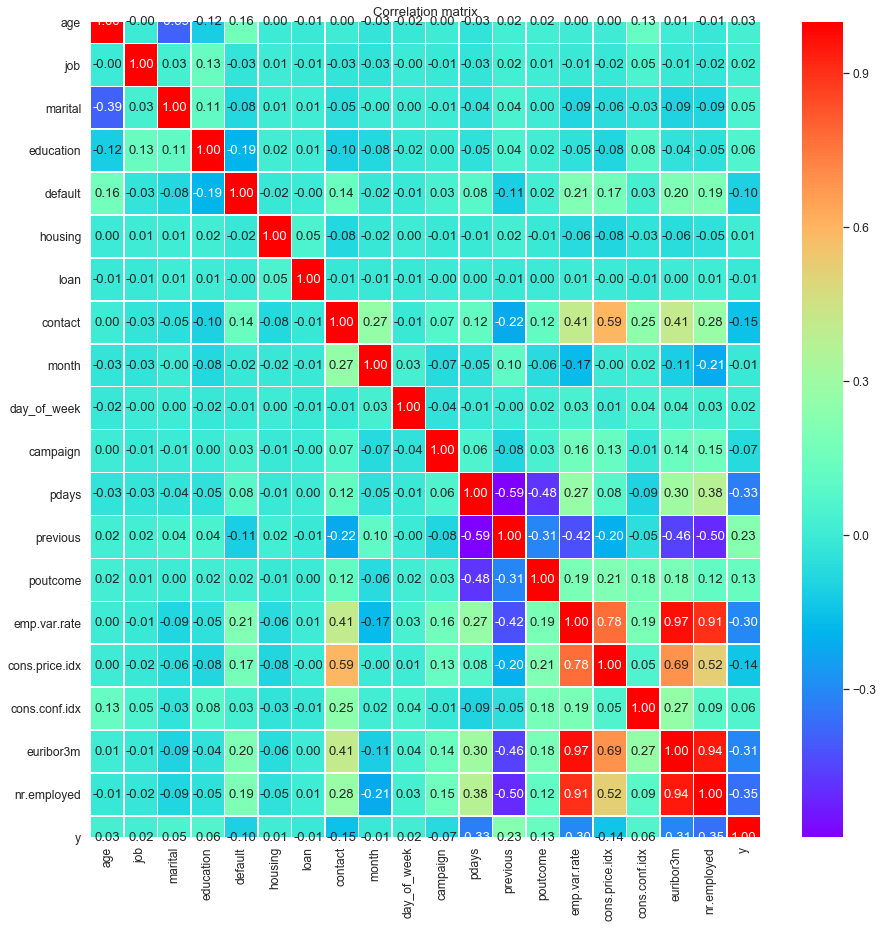

In [37]:
# Correlation matrix.
plt.figure(figsize=(15,15))
sns.set(font_scale=1.1)
sns.heatmap(data.corr(),annot=True, cmap='rainbow',linewidth=0.5, fmt='.2f')
plt.title('Correlation matrix');

## Part 2: Pre-processing

In this part we prepare our data for our models. This means that we choose the columns that will be our independed variables and which column the class that we want to predict. Once we are done with that, we split our data into train and test sets and perfom a standardization upon them.

In [18]:
# Distinguish attribute columns and class column.
X=data[data.columns[:-1]]
y=data['y']

In [19]:
# Split to train and test sets. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)

In [20]:
# Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Part 3: Modeling

In this section we build and try 3 models:
 - Logistic Regression
 - Decision tree
 - Neural network

Each model will be trained and make a prediction for the test set. Accuracy, f1 score, confusion matrix and ROC will be calculated for each model. Then we will use the `GridSearchCV` module to tune our models and search for the best hyperparameters in order to increase the accuracy of each model.

## Logistic Regression

In [21]:
# Initialize a Logistic Regression estimator.
logreg=LogisticRegression(multi_class='auto', random_state=25, n_jobs=-1)

# Train the estimator.
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=25,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [22]:
# Make predictions.
log_pred=logreg.predict(X_test)

# CV score for MLP
cv_logreg=cross_val_score(logreg, X_train, y_train, cv=10).mean()

## Metrics for Logistic Regression

In [23]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % logreg.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % cv_logreg)

# Precision
print('Precision: %.3f' % precision_score(y_test, log_pred))

# Recall
print('Recall: %.3f' % recall_score(y_test, log_pred))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, log_pred))

Accuracy: 0.895
Cross-validation accuracy: 0.897
Precision: 0.656
Recall: 0.200
F1 score: 0.307


In [24]:
# Predict probabilities for the test data.
logreg_probs = logreg.predict_proba(X_test)

# Keep Probabilities of the positive class only.
logreg_probs = logreg_probs[:, 1]

# Compute the AUC Score.
auc_logreg = roc_auc_score(y_test, logreg_probs)
print('AUC: %.2f' % auc_logreg)

AUC: 0.78


## Confusion matrix for Logistic Regression

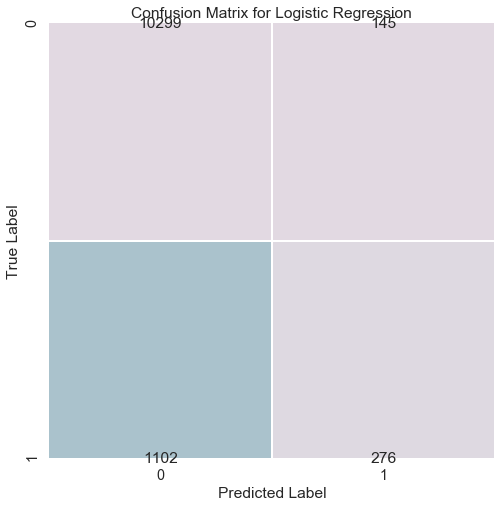

In [25]:
# Plot confusion matrix for Logistic Regression.
logreg_matrix = confusion_matrix(y_test,log_pred)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8, 8))
sns.heatmap(logreg_matrix, annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Logistic Regression');

## Grid search for Logistic Regression

In [18]:
# Hyperparameters to be checked.
parameters = {'C':[0.0001, 0.001, 0.01, 1, 0.1, 10, 100, 1000],
              'penalty':['none','l2'] ,
              'solver':['lbfgs','sag','saga','newton-cg']
             }

# Logistic Regression estimator.
default_logreg=LogisticRegression(multi_class='auto', random_state=25, n_jobs=-1)

# GridSearchCV estimator.
gs_logreg = GridSearchCV(default_logreg, parameters, cv=10, n_jobs=-1, verbose=1)

# Train the GridSearchCV estimator and search for the best parameters.
gs_logreg.fit(X_train,y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  1.5min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=25, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 1, 0.1, 10, 100, 1000],
                         'penalty': ['none', 'l2'],
                         'solver': ['lbfgs', 'sag', 'saga', 'newton-cg']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [19]:
# Make predictions with the best parameters.
gs_log_pred=gs_logreg.predict(X_test)

## Grid search metrics for Logistic Regression 

In [20]:
# Best parameters.
print("Best Logistic Regression Parameters: {}".format(gs_logreg.best_params_))

# Cross validation accuracy for the best parameters.
print('Cross-validation accuracy: %0.3f' % gs_logreg.best_score_)

# Accuracy: 1 is perfect prediction.
print('Accuracy: %0.3f' % (gs_logreg.score(X_test,y_test)))

# Precision
print('Precision: %.3f' % precision_score(y_test, gs_log_pred))

# Recall
print('Recall: %.3f' % recall_score(y_test, gs_log_pred))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, gs_log_pred))

Best Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Cross-validation accuracy: 0.898
Accuracy: 0.895
Precision: 0.670
Recall: 0.190
F1 score: 0.296


In [21]:
# Predict probabilities for the test data.
gs_logreg_probs = gs_logreg.predict_proba(X_test)

# Keep Probabilities of the positive class only.
gs_logreg_probs = gs_logreg_probs[:, 1]

# Compute the AUC Score.
gs_logreg_auc = roc_auc_score(y_test, gs_logreg_probs)
print('AUC: %.2f' % gs_logreg_auc)

AUC: 0.77


## Confusion Matrix for Grid search Logistic Regression

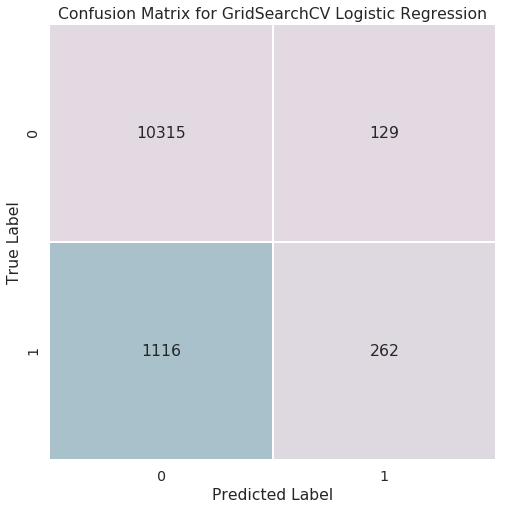

In [22]:
# Print confusion matrix for Logistic regression.
gs_logreg_matrix = confusion_matrix(y_test,gs_log_pred)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8, 8))
sns.heatmap(gs_logreg_matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for GridSearchCV Logistic Regression');

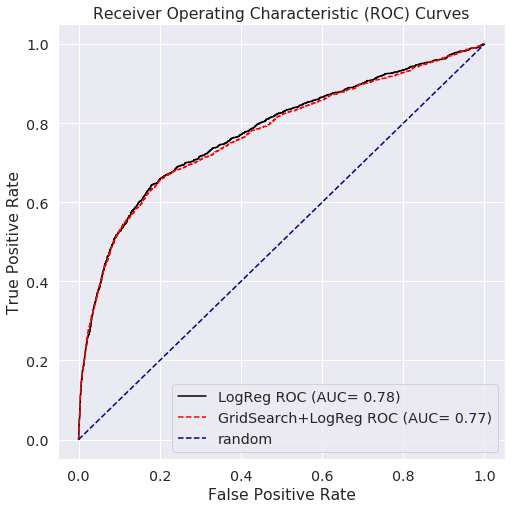

In [23]:
# Get the ROC curves.
logreg_fpr, logreg_tpr, logreg_thresholds = roc_curve(y_test, logreg_probs)
gs_logreg_fpr, gs_logreg_tpr, gs_logreg_thresholds = roc_curve(y_test, gs_logreg_probs)

# Plot the ROC curves.
plt.figure(figsize=(8,8))
plt.plot(logreg_fpr, logreg_tpr, color='black', label='LogReg ROC (AUC= %0.2f)'% auc_logreg)
plt.plot(gs_logreg_fpr, gs_logreg_tpr, color='red', linestyle='--',label='GridSearch+LogReg ROC (AUC= %0.2f)'% gs_logreg_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()

## Decision tree

In [26]:
# Initialize a decision tree estimator.
tr = tree.DecisionTreeClassifier(max_depth=3,random_state=25)

# Train the estimator.
tr.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=25, splitter='best')

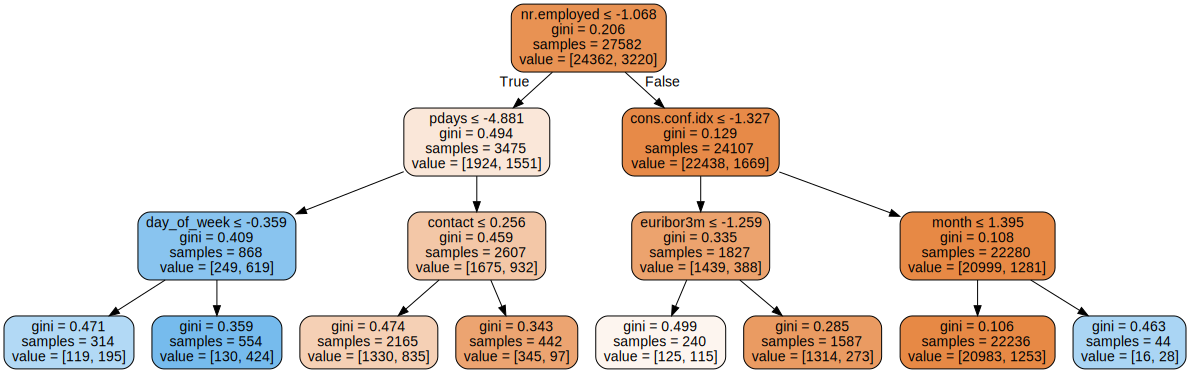

In [29]:
# Plot the tree.

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = tree.export_graphviz(tr, out_file=None, feature_names=X.columns, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

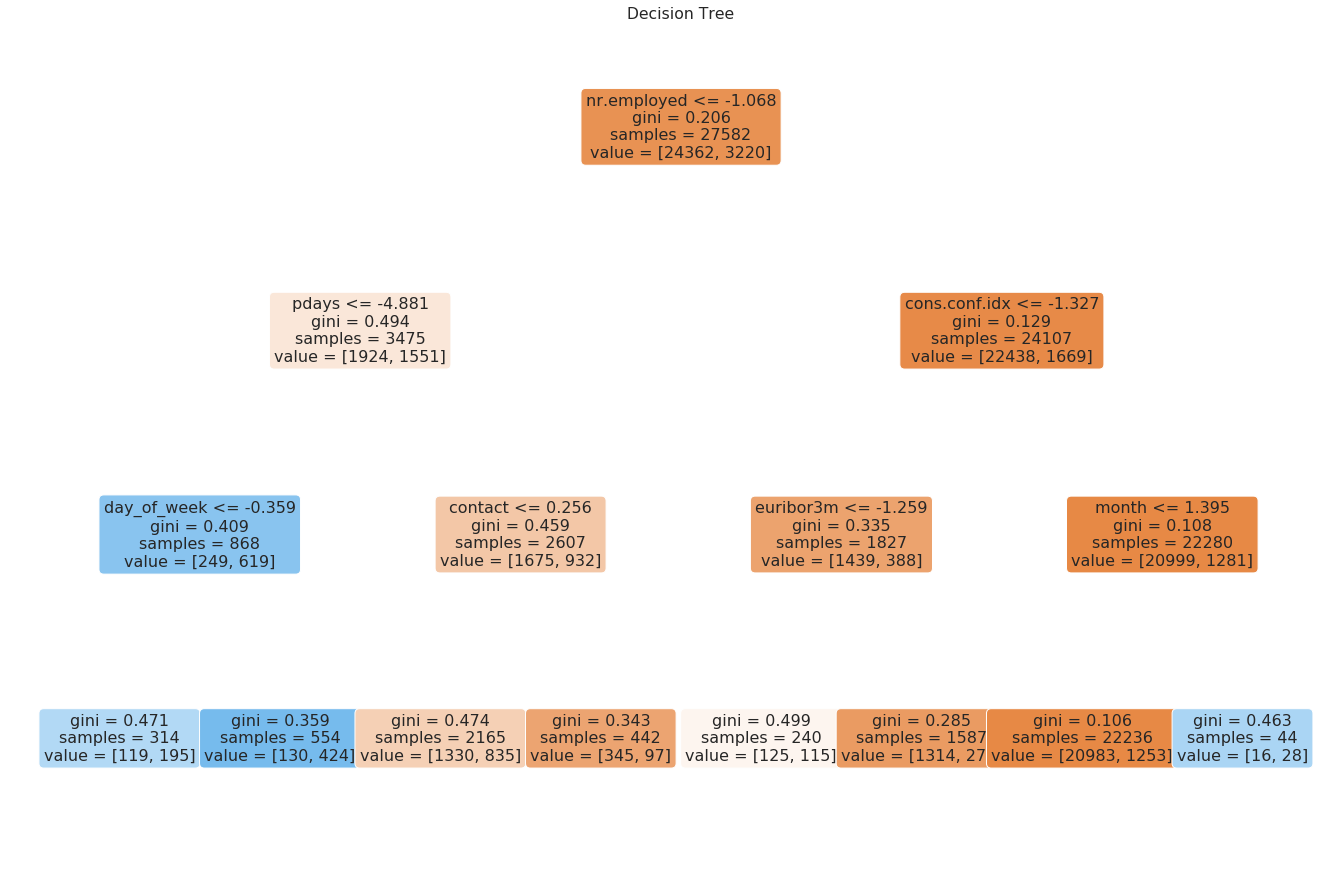

In [25]:
# Plot the tree.
fig=plt.figure(figsize=(23,15))
tree.plot_tree(tr.fit(X_train, y_train),feature_names=X.columns,filled=True,rounded=True,fontsize=16);
plt.title('Decision Tree');

In [26]:
# Print the tree in a simplified version.
r = export_text(tr, feature_names=X.columns.tolist())
print(r)

|--- nr.employed <= -1.07
|   |--- pdays <= -4.88
|   |   |--- day_of_week <= -0.36
|   |   |   |--- class: 1
|   |   |--- day_of_week >  -0.36
|   |   |   |--- class: 1
|   |--- pdays >  -4.88
|   |   |--- contact <= 0.26
|   |   |   |--- class: 0
|   |   |--- contact >  0.26
|   |   |   |--- class: 0
|--- nr.employed >  -1.07
|   |--- cons.conf.idx <= -1.33
|   |   |--- euribor3m <= -1.26
|   |   |   |--- class: 0
|   |   |--- euribor3m >  -1.26
|   |   |   |--- class: 0
|   |--- cons.conf.idx >  -1.33
|   |   |--- month <= 1.39
|   |   |   |--- class: 0
|   |   |--- month >  1.39
|   |   |   |--- class: 1



In [27]:
# Make predictions.
tr_pred=tr.predict(X_test)

# CV score for Decision tree
cv_tr=cross_val_score(tr, X_train, y_train, cv=10).mean()

## Metrics for Decision tree

In [28]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % tr.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % cv_tr)

# Precision
print('Precision: %.3f' % precision_score(y_test, tr_pred))

# Recall
print('Precision: %.3f' % recall_score(y_test, tr_pred))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, tr_pred))

Accuracy: 0.895
Cross-validation accuracy: 0.896
Precision: 0.687
Precision: 0.180
F1 score: 0.285


In [29]:
# Predict propabilities for the test data.
tr_probs = tr.predict_proba(X_test)

# Keep Probabilities of the positive class only.
tr_probs = tr_probs[:, 1]

# Compute the AUC Score.
auc_tr = roc_auc_score(y_test, tr_probs)
print('AUC: %.2f' % auc_tr)

AUC: 0.74


## Confusion Matrix for Decision tree

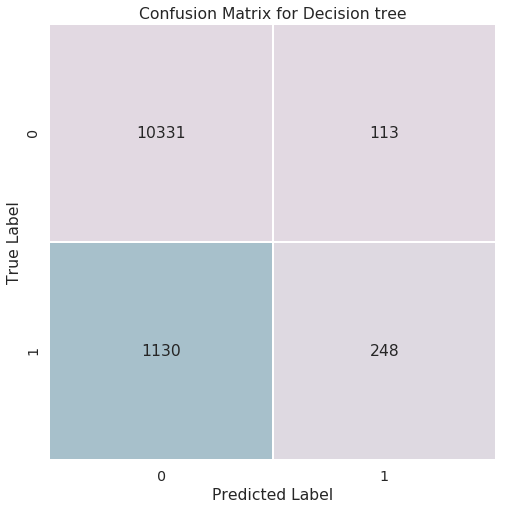

In [30]:
# Print confusion matrix for Decision tree.
tr_matrix = confusion_matrix(y_test,tr_pred)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8,8))
sns.heatmap(tr_matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Decision tree');

## Grid search for Decision tree

In [31]:
# Hyperparameters to be checked.
parameters = {'criterion':['gini','entropy'],
              'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
             }

# MLP estimator.
default_tr = tree.DecisionTreeClassifier(random_state=25)

# GridSearchCV estimator.
gs_tree = GridSearchCV(default_tr, parameters, cv=10, n_jobs=-1,verbose=1)

# Train the GridSearchCV estimator and search for the best parameters.
gs_tree.fit(X_train,y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   18.2s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=25,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
  

In [32]:
# Make predictions with the best parameters.
gs_tree_pred=gs_tree.predict(X_test)

## Grid search metrics for Decision tree

In [33]:
# Best parameters.
print("Best Decision tree Parameters: {}".format(gs_tree.best_params_))

# Cross validation accuracy for the best parameters.
print('Cross-validation accuracy: %0.3f' % gs_tree.best_score_)

# Accuracy: 1 is perfect prediction.
print('Accuracy: %0.3f' % (gs_tree.score(X_test,y_test)))

# Precision
print('Precision: %.3f' % precision_score(y_test, gs_tree_pred))

# Recall
print('Recall: %.3f' % recall_score(y_test, gs_tree_pred))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, gs_tree_pred))

Best Decision tree Parameters: {'criterion': 'entropy', 'max_depth': 5}
Cross-validation accuracy: 0.897
Accuracy: 0.897
Precision: 0.643
Recall: 0.259
F1 score: 0.369


In [34]:
# Predict probabilities for the test data.
gs_tree_probs = gs_tree.predict_proba(X_test)

# Keep Probabilities of the positive class only.
gs_tree_probs = gs_tree_probs[:, 1]

# Compute the AUC Score.
gs_tree_auc = roc_auc_score(y_test, gs_tree_probs)
print('AUC: %.2f' % gs_tree_auc)

AUC: 0.78


## Confusion Matrix for Grid search Decision tree

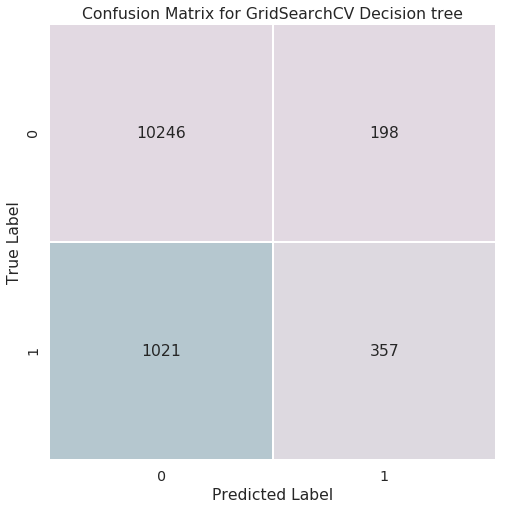

In [35]:
# Print confusion matrix for Decision tree.
gs_tr_matrix = confusion_matrix(y_test,gs_tree_pred)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8, 8))
sns.heatmap(gs_tr_matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for GridSearchCV Decision tree');

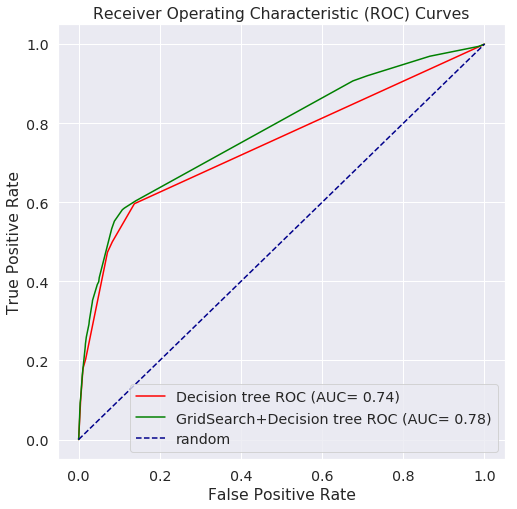

In [36]:
# Get the ROC Curves.
gs_tr_fpr, gs_tr_tpr, gs_tr_thresholds = roc_curve(y_test, gs_tree_probs)
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_test, tr_probs)

# Plot the ROC curves.
plt.figure(figsize=(8,8))
plt.plot(tr_fpr, tr_tpr, color='red', label='Decision tree ROC (AUC= %0.2f)'% auc_tr)
plt.plot(gs_tr_fpr, gs_tr_tpr, color='green', label='GridSearch+Decision tree ROC (AUC= %0.2f)'% gs_tree_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()

## Neural network (MLP)

In [37]:
# Initialize a Multi-layer Perceptron classifier.
mlp = MLPClassifier(hidden_layer_sizes=(100),max_iter=1000, random_state=25,shuffle=True,)

# Train the classifier.
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=100, learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=25, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [38]:
# Make predictions.
mlp_pred = mlp.predict(X_test)

# CV score for MLP
cv_mlp=cross_val_score(mlp, X_train, y_train, cv=10).mean()

## Metrics for Neural network (MLP)

In [39]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % mlp.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % cv_mlp)

# Precision
print('Precision: %.3f' % precision_score(y_test, mlp_pred))

# Recall
print('Recall: %.3f' % recall_score(y_test, mlp_pred))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, mlp_pred))

Accuracy: 0.888
Cross-validation accuracy: 0.891
Precision: 0.544
Recall: 0.253
F1 score: 0.345


In [40]:
# Predict probabilities for the test data.
mlp_probs = mlp.predict_proba(X_test)

# Keep probabilities of the positive class only.
mlp_probs = mlp_probs[:, 1]

# Compute the AUC Score.
auc_mlp = roc_auc_score(y_test, mlp_probs)
print('AUC: %.2f' % auc_mlp)

AUC: 0.76


## Confusion Matrix for Neural network (MLP)

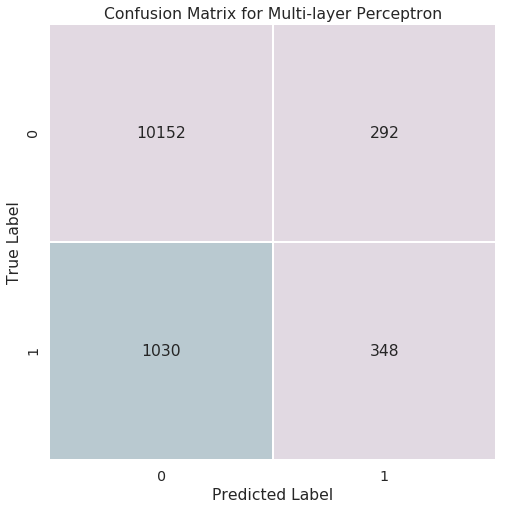

In [41]:
# Print confusion matrix for Multi-layer Perceptron.
matrix = confusion_matrix(y_test,mlp_pred)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8, 8))
sns.heatmap(matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Multi-layer Perceptron');

## Grid search for Neural network (MLP)

In [42]:
# Hyperparameters to be checked.
parameters = {'activation':['logistic','relu'],'solver': ['lbfgs','adam','sgd'],
              'alpha':10.0 ** -np.arange(1,4),
              'hidden_layer_sizes':[(20),(4),(10),(14,2),(4,1),(10,5),(11,3)]}

# Decision tree estimator.
default_mlp = MLPClassifier(random_state=25)

# GridSearchCV estimator.
gs_mlp = GridSearchCV(default_mlp, parameters, cv=10, n_jobs=-1,verbose=1)

# Train the GridSearchCV estimator and search for the best parameters.
gs_mlp.fit(X_train,y_train)

Fitting 10 folds for each of 126 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 36.0min
[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed: 36.6min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_st...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['logistic', 'relu'],
                         '

In [43]:
# Make predictions with the best parameters.
gs_mlp_pred=gs_mlp.predict(X_test)

## Grid search metrics for Neural network (MLP)

In [44]:
# Best parameters.
print("Best MLP Parameters: {}".format(gs_mlp.best_params_))

# Cross validation accuracy for the best parameters.
print('Cross-validation accuracy: %0.3f' % gs_mlp.best_score_)

# Accuracy: 1 is perfect prediction.
print('Accuracy: %0.3f' % (gs_mlp.score(X_test,y_test)))

# Precision
print('Precision: %.3f' % precision_score(y_test, gs_mlp_pred))

# Recall
print('Recall: %.3f' % recall_score(y_test, gs_mlp_pred))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, gs_mlp_pred))

Best MLP Parameters: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 10, 'solver': 'adam'}
Cross-validation accuracy: 0.898
Accuracy: 0.895
Precision: 0.667
Recall: 0.202
F1 score: 0.310


In [45]:
# Predict probabilities for the test data.
gs_mlp_probs = gs_mlp.predict_proba(X_test)

# Keep Probabilities of the positive class only.
gs_mlp_probs = gs_mlp_probs[:, 1]

# Compute the AUC Score.
gs_mlp_auc = roc_auc_score(y_test, gs_mlp_probs)
print('AUC: %.2f' % gs_mlp_auc)

AUC: 0.78


## Confusion Matrix for Neural network (MLP)

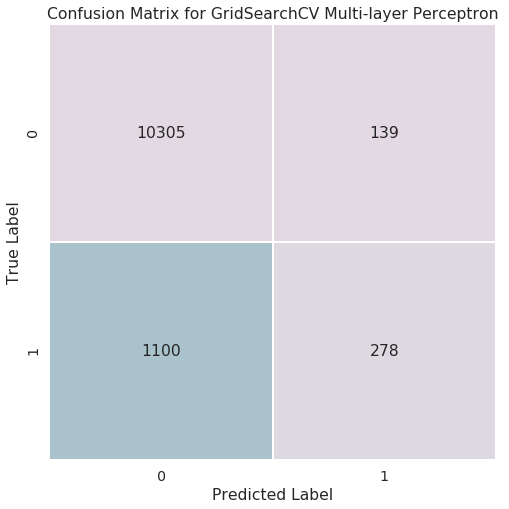

In [46]:
# Plot confusion matrix for GridSearchCV Multi-layer Perceptron.
matrix = confusion_matrix(y_test,gs_mlp_pred)
plt.figure(figsize=(8,8))
sns.heatmap(matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for GridSearchCV Multi-layer Perceptron');

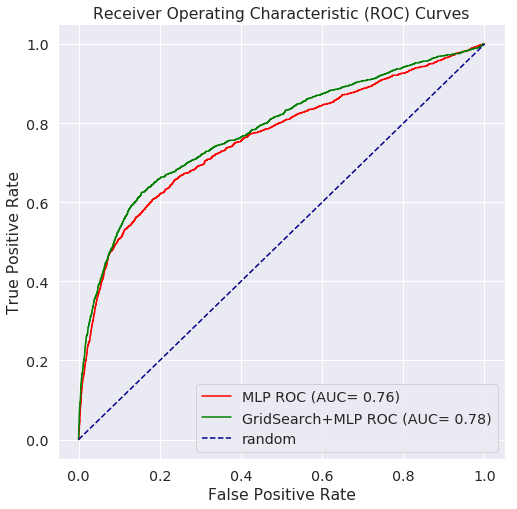

In [47]:
# Get the ROC curves.
gs_mlp_fpr, gs_mlp_tpr,gs_mlp_thresholds = roc_curve(y_test, gs_mlp_probs)
mlp_fpr, mlp_tpr, mlp_thresholds = roc_curve(y_test, mlp_probs)

# Plot the ROC curve.
plt.figure(figsize=(8,8))
plt.plot(mlp_fpr, mlp_tpr, color='red', label='MLP ROC (AUC= %0.2f)'% auc_mlp)
plt.plot(gs_mlp_fpr, gs_mlp_tpr, color='green', label='GridSearch+MLP ROC (AUC= %0.2f)'% gs_mlp_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()

## Results

In [48]:
metrics=['Accuracy','CV accuracy','Precision','Recall','F1','ROC AUC']

# Plot metrics.
fig = go.Figure(data=[
    go.Bar(name='Logistic Regression', x=metrics,
           y=[logreg.score(X_test, y_test),cv_logreg,precision_score(y_test, log_pred),recall_score(y_test, log_pred),f1_score(y_test, log_pred),auc_logreg]),
    go.Bar(name='Decision tree', x=metrics,
           y=[tr.score(X_test, y_test),cv_tr,precision_score(y_test, tr_pred),recall_score(y_test, tr_pred),f1_score(y_test, tr_pred),auc_tr]),
    go.Bar(name='Neural Network', x=metrics,
           y=[mlp.score(X_test, y_test),cv_mlp,precision_score(y_test, mlp_pred),recall_score(y_test, mlp_pred),f1_score(y_test, mlp_pred),auc_mlp]),
    go.Bar(name='GridSearchCV+Logistic Regression',x=metrics,
           y=[gs_logreg.score(X_test,y_test),gs_logreg.best_score_,precision_score(y_test, gs_log_pred),recall_score(y_test, gs_log_pred),f1_score(y_test, gs_log_pred),gs_logreg_auc]),
    go.Bar(name='GridSearchCV+Decision tree',x=metrics,
           y=[gs_tree.score(X_test,y_test),gs_tree.best_score_,precision_score(y_test, gs_tree_pred),recall_score(y_test, gs_tree_pred), f1_score(y_test, gs_tree_pred),gs_tree_auc]),
    go.Bar(name='GridSearchCV+Neural Network', x=metrics, 
           y=[gs_mlp.score(X_test,y_test),gs_mlp.best_score_,precision_score(y_test, gs_mlp_pred),recall_score(y_test, gs_mlp_pred), f1_score(y_test, gs_mlp_pred),gs_mlp_auc])
    ])

fig.update_layout(title_text='Metrics for all models',
                  barmode='group',xaxis_tickangle=-45,bargroupgap=0.05)
fig.show()

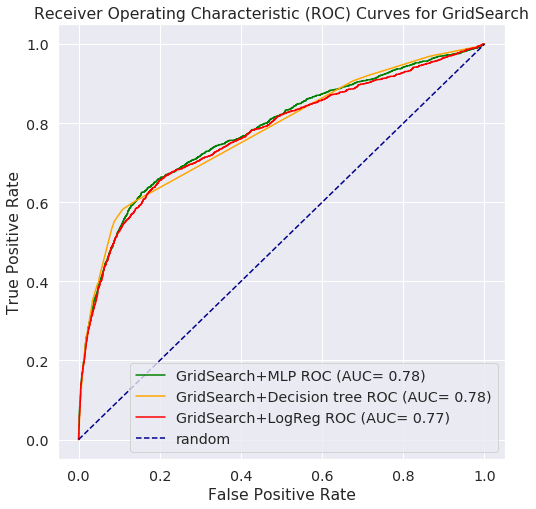

In [49]:
# Plot the ROC curve.
plt.figure(figsize=(8,8))
plt.plot(gs_mlp_fpr, gs_mlp_tpr, color='green', label='GridSearch+MLP ROC (AUC= %0.2f)'% gs_mlp_auc)
plt.plot(gs_tr_fpr, gs_tr_tpr, color='orange', label='GridSearch+Decision tree ROC (AUC= %0.2f)'% gs_tree_auc)
plt.plot(gs_logreg_fpr, gs_logreg_tpr, color='red',label='GridSearch+LogReg ROC (AUC= %0.2f)'% gs_logreg_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for GridSearch')
plt.legend()
plt.show()

In [50]:
d={
'': ['Logistic Regression','GridSearchCV + Logistic Regression','Decision Tree','GridSearchCV + Decision Tree','Neural Network (MLP)','GridSearchCV + Neural Network (MLP)'],
'Accuracy': [logreg.score(X_test, y_test), gs_logreg.score(X_test,y_test),tr.score(X_test, y_test),gs_tree.score(X_test,y_test),mlp.score(X_test, y_test),gs_mlp.score(X_test, y_test)],
'CV Accuracy': [cv_logreg, gs_logreg.best_score_, cv_tr,gs_tree.best_score_,cv_mlp,gs_mlp.best_score_],
'Precision': [precision_score(y_test, log_pred), precision_score(y_test, gs_log_pred),precision_score(y_test, tr_pred),precision_score(y_test, gs_tree_pred),precision_score(y_test, mlp_pred),precision_score(y_test, gs_mlp_pred)],
'Recall': [recall_score(y_test, log_pred), recall_score(y_test, gs_log_pred),recall_score(y_test, tr_pred),recall_score(y_test, gs_tree_pred),recall_score(y_test, mlp_pred),recall_score(y_test, gs_mlp_pred)],
'F1': [f1_score(y_test, log_pred), f1_score(y_test, gs_log_pred),f1_score(y_test, tr_pred),f1_score(y_test, gs_tree_pred),f1_score(y_test, mlp_pred),f1_score(y_test, gs_mlp_pred)],
'ROC AUC': [auc_logreg, gs_logreg_auc, auc_tr, gs_tree_auc, auc_mlp, gs_mlp_auc]
}

results=pd.DataFrame(data=d).round(3).set_index('')
results

,Accuracy,CV Accuracy,Precision,Recall,F1,ROC AUC
,,,,,,
Logistic Regression,0.895,0.897,0.656,0.200,0.307,0.778
GridSearchCV + Logistic Regression,0.895,0.898,0.670,0.190,0.296,0.772
Decision Tree,0.895,0.896,0.687,0.180,0.285,0.745
GridSearchCV + Decision Tree,0.897,0.897,0.643,0.259,0.369,0.777
Neural Network (MLP),0.888,0.891,0.544,0.253,0.345,0.761
GridSearchCV + Neural Network (MLP),0.895,0.898,0.667,0.202,0.310,0.781
